<h1>Dataset<h1>

In [4]:
#Importing the dataset
import pandas as pd
df_ecb = pd.read_csv('/Users/shivangeeacharya/Downloads/ECB/mon_ecb.csv')
df_ecb.head()

Title  \
0  Liquidity conditions and monetary policy opera...   
1  Public loan guarantees and bank lending in the...   
2  Automatic fiscal stabilisers in the euro area ...   
3  The impact of the recent spike in uncertainty ...   
4  The Bulgarian lev and the Croatian kuna in the...   

                                                href  \
0  https://www.ecb.europa.eu/pub/economic-bulleti...   
1  https://www.ecb.europa.eu/pub/economic-bulleti...   
2  https://www.ecb.europa.eu/pub/economic-bulleti...   
3  https://www.ecb.europa.eu/pub/economic-bulleti...   
4  https://www.ecb.europa.eu/pub/economic-bulleti...   

                                             content  
0  Liquidity conditions and monetary policy opera...  
1  Public loan guarantees and bank lending in the...  
2  Automatic fiscal stabilisers in the euro area ...  
3  The impact of the recent spike in uncertainty ...  
4  The Bulgarian lev and the Croatian kuna in the...

<h1>Latent Dirichlet Allocation<h1>

In [6]:
#NECESSARY PACKAGES

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
#We create the list of stop words that we want to eliminate out of our corpus.
stop_list_1_ecb = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
             "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 
             'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
             'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
             'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 
             'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
             'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
             'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
             'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
             'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
             'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
             'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
             't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 
             'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
             "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'will','would',
              'can','could','shall','should']
stop_list_2_ecb = ['by','continuing','to','use','this','website','you','grant','your','approval','of','the','use',
               'of','cookies','separate','ecbute','of','the','executive','board','meeting','on','january','present',
               'urban','bäckström','chairman','lars','heikensten','eva','srejber','villy','bergström','kerstin',
               'hessius','lars','nyberg','kerstin','alm','björn','hasselgren','sven','hulterström','robert',
               'sparve','åsa','sydén','michael','wallin','the','riksbank','deputy','governor','lars','heikensten',
               'proposed','the','announcement','of','proposal','this','ecbute','was','immediately','confirmed''governing',
               'council','also','m','claes','berg','hans','dillén','richard','gröttheim','per','jansson','hans','lindberg',
               'hans','lindblad','christina','lindenius','pernilla','meyersson','joachim','wadefjord','per','walter','staffan','viotti',
               'göran','mr','mrs','mr.','zettergren','telephone','monetary','policy',
               'jan','january','feb','february','mar','march','apr','april','may','jun','june','jul','july',
               'aug','august','sept','september','oct','october','nov','november','dec','december',
               'repo','rate','sively','year','m','governing','svensson','johan','m','m ']

stop_ecb = stop_list_1_ecb + stop_list_2_ecb

In [9]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized_all_df_ecb = []
collocations_all = []
#bow_all = Counter()
for i1 in range(len(df_ecb)):
    text = df_ecb.at[i1,'content'].split(' ')
    tag = nltk.pos_tag([i for i in text if i])
    pos_tag_clean = [x for (x,y) in tag if y not in ('PRP$', 'NNPS', 'PRP','NNP','IN')]
    text_lower = [t.lower() for t in pos_tag_clean]
    tokens = [w for w in text_lower if w.isalpha()]
    #tokens_all.append(tokens)
    no_stops = [t for t in tokens if t not in stop_ecb]
    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    # Create the bag-of-words: bow
    bow = Counter(lemmatized)
    lemmatized_all_df_ecb.append(lemmatized)
    # Create the bag-of-words: bow
    sent = df_ecb.at[i1,'content'].split('.')
    df_ecb.at[i1,'no. of sentences'] = len(sent)
    #find_bigrams
    words = [word.lower() for word in pos_tag_clean 
             if len(word) > 2 
             and word not in stop_ecb]
    finder = BigramCollocationFinder.from_words(words)
    bgm = BigramAssocMeasures()
    score = bgm.mi_like
    collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}#Pointwise Mutual Information
    collocations_all.append(collocations)

<h2>LDA without tf-idf<h2>

In [10]:
# Import Dictionary
from gensim.corpora import Dictionary
# Create a Dictionary from the total number of documents collected: dictionary_ecb
dictionary_ecb = Dictionary(lemmatized_all_df_ecb)

# Create a Corpus: corpus_ecb
corpus_ecb = [dictionary_ecb.doc2bow(word) for word in lemmatized_all_df_ecb]

# Print the first 10 word ids with their frequency counts from the fifth document
print(corpus_ecb[4][:10])

[(4, 2), (7, 2), (21, 3), (26, 1), (29, 5), (30, 3), (41, 3), (42, 2), (43, 11), (44, 2)]


In [11]:
lda_model_ecb = gensim.models.ldamodel.LdaModel(corpus = corpus_ecb,
                                           id2word = dictionary_ecb, 
                                           num_topics = 10, 
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto', 
                                           per_word_topics=True) 
#id2word: Mapping from word IDs to words
#chunksize: Number of documents to be used in each training chunk
#update_every: determines how often the model parameters should be updated 
#passes: Number of passes through the corpus during training
#alpha: expresses our a-priori belief for the each topics’ probability
# per_word_topics(bool):  If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word
lda_model_ecb.print_topics()

[(0,
  '0.041*"tracer" + 0.006*"lagging" + 0.003*"executive" + 0.002*"tracked" + 0.002*"rubber" + 0.002*"dichotomy" + 0.002*"visually" + 0.002*"interpretability" + 0.002*"strengthens" + 0.002*"centrality"'),
 (1,
  '0.017*"growth" + 0.014*"euro" + 0.013*"area" + 0.010*"price" + 0.010*"projection" + 0.009*"model" + 0.009*"expected" + 0.008*"real" + 0.008*"quarter" + 0.008*"economic"'),
 (2,
  '0.048*"market" + 0.024*"second" + 0.023*"survey" + 0.020*"quarter" + 0.019*"money" + 0.017*"euro" + 0.017*"turnover" + 0.015*"study" + 0.014*"result" + 0.013*"expert"'),
 (3,
  '0.150*"inflation" + 0.058*"price" + 0.032*"measure" + 0.027*"underlying" + 0.019*"expectation" + 0.017*"curve" + 0.013*"change" + 0.011*"service" + 0.011*"index" + 0.011*"food"'),
 (4,
  '0.068*"fiscal" + 0.035*"economic" + 0.034*"government" + 0.032*"present" + 0.018*"chapter" + 0.018*"public" + 0.017*"provide" + 0.016*"edition" + 0.015*"rule" + 0.015*"balance"'),
 (5,
  '0.075*"exchange" + 0.052*"import" + 0.049*"global"

We carry out the following process repeatedly to form wordclouds:

In [12]:
topics = []
for index, topic in lda_model_ecb.show_topics(formatted=False, num_words= 30):
    #print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    topics.append(topic)

In [13]:
t = lda_model_ecb.show_topics(num_words= 10)
w0_ecb = []
for i1 in range(10):
    t1 = list(t[i1])
    t2 = t1[1].split('+')
    t3 = [t2.split('*') for t2 in t2]
    #t3[0][1]
    w1 = []
    for i2 in  range(len(t3)):
        w1.append(t3[i2][1])
        for i3 in range(len(w1)):
            w1[i3] = w1[i3].replace('"','').strip()
    w0_ecb.append(w1)

In [14]:
topics_df_ecb = pd.DataFrame([[term for term in topic] for topic in w0_ecb], columns = ['Term'+str(i) for i in range(1, 11)], index=['Topic '+str(t) for t in range(1, lda_model_ecb.num_topics+1)]).T
topics_df_ecb.head()

Topic 1     Topic 2  Topic 3      Topic 4     Topic 5   Topic 6  \
Term1     tracer      growth   market    inflation      fiscal  exchange   
Term2    lagging        euro   second        price    economic    import   
Term3  executive        area   survey      measure  government    global   
Term4    tracked       price  quarter   underlying     present     price   
Term5     rubber  projection    money  expectation     chapter    export   

          Topic 7  Topic 8 Topic 9   Topic 10  
Term1        area     bank    area     report  
Term2        euro     loan    euro    version  
Term3   financial     rate  labour    central  
Term4       sheet  lending  market  framework  
Term5  regulatory   credit  reform   european

In [15]:
pd.set_option('display.max_colwidth', -1)
topics_df_ecb= pd.DataFrame([', '.join([term for term in topic]) for topic in w0_ecb], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model_ecb.num_topics+1)] )
topics_df_ecb

<ipython-input-15-fc1cc50cf0ef>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Terms per Topic
Topic1   tracer, lagging, executive, tracked, rubber, dichotomy, visually, interpretability, strengthens, centrality
Topic2   growth, euro, area, price, projection, model, expected, real, quarter, economic                            
Topic3   market, second, survey, quarter, money, euro, turnover, study, result, expert                              
Topic4   inflation, price, measure, underlying, expectation, curve, change, service, index, food                    
Topic5   fiscal, economic, government, present, chapter, public, provide, edition, rule, balance                    
Topic6   exchange, import, global, price, export, trade, value, domestic, foreign, production                       
Topic7   area, euro, financial, sheet, regulatory, selected, network, aggregate, programme, balance                 
Topic8   bank, loan, rate, lending, credit, interest, negative, condition, firm, impact                             
Topic9   area, euro, labour, market, reform, wage, country, potential, effect, unemployment                         
Topic10  report, version, central, framework, european, available, today, document, instrument, entitled

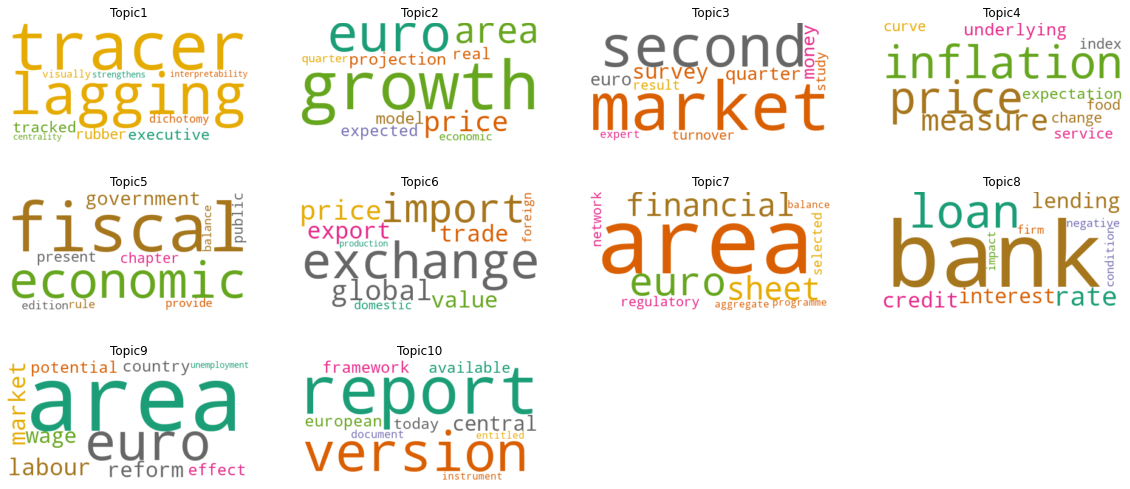

In [145]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text = topics_df_ecb["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df_ecb.index[i])
plt.savefig('ecb_wo_tfidf_WordCloud.png', dpi = 100, bbox_inches = 'tight')
plt.show()

<h3>Coherence Scores<h3>

In [91]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model_ecb, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
coherence_lda_ecb = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_ecb)


Coherence Score:  0.4245651059694785


In [101]:
# Compute Coherence Score using UMass
coherence_model_lda_umass = CoherenceModel(model=lda_model_ecb, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence="u_mass")
coherence_lda_umass = coherence_model_lda_umass.get_coherence()
print('\nCoherence Score: ', coherence_lda_umass)


Coherence Score:  -1.872685699740306


In [92]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_ecb.log_perplexity(corpus_ecb))  # a measure of how good the model is. lower the better.


Perplexity:  -7.088023703027946


<h3>Optimal number of topics<h3>

In [106]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus_ecb, id2word = dictionary_ecb, num_topics = num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

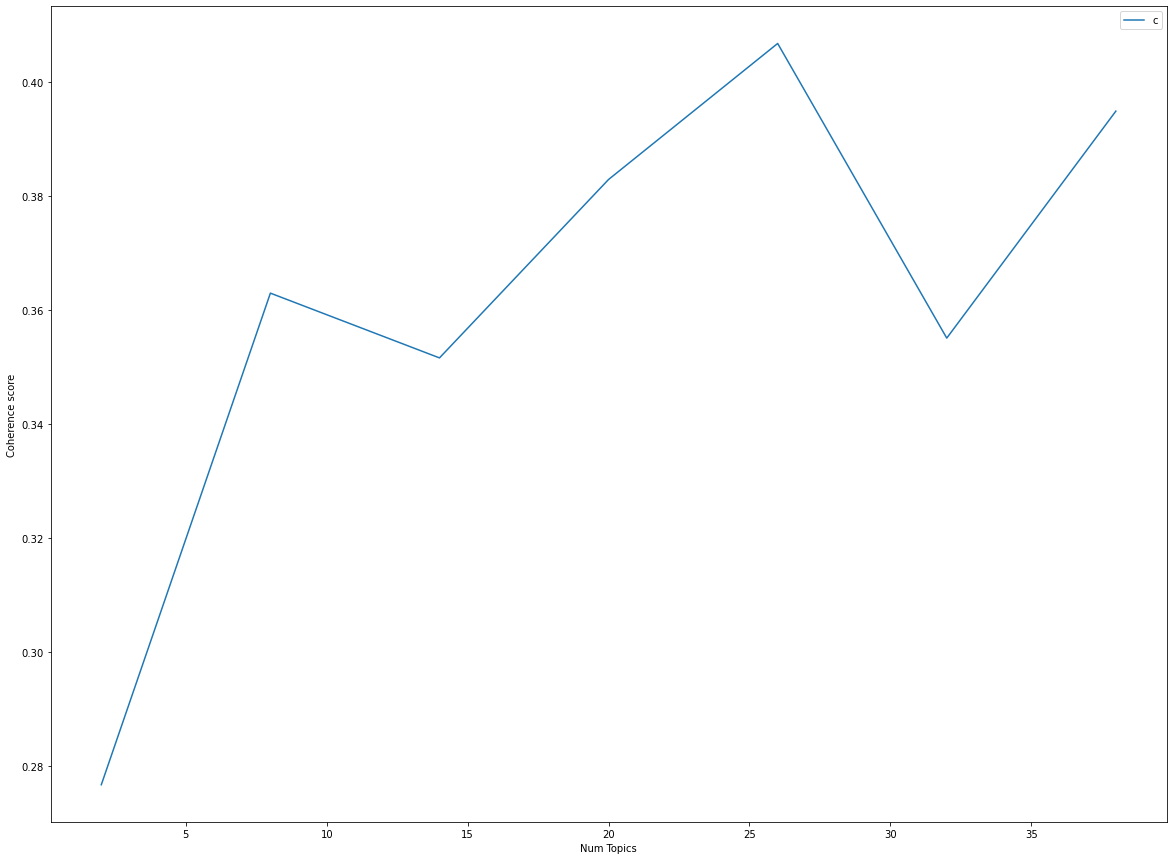

In [107]:
model_list, coherence_values = compute_coherence_values(dictionary = dictionary_ecb, corpus = corpus_ecb,
                                                        texts = lemmatized_all_df_ecb, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

<h2>LDA with tf-idf<h2>

In [22]:
doc_all_ecb = []
bow_doc_all_ecb = []
from collections import defaultdict
import itertools
# Save the fifth document: doc
len1 = 0
for i in range(len(corpus_ecb)):
    doc = corpus_ecb[i]
    len1 = len1 + (len(corpus_ecb[i])) 
    doc_all_ecb.append(doc)
    # Sort the doc for frequency: bow_doc
    bow_doc = sorted(doc, key=lambda w: w[1], reverse=True)
    bow_doc_all_ecb.append(bow_doc)
    # Print the top 5 words of the document alongside the count
    #for word_id, word_count in bow_doc[:5]:
        #print(dictionary.get(word_id), word_count)

    # Create the defaultdict: total_word_count
    total_word_count = defaultdict(int)
    for word_id, word_count in itertools.chain.from_iterable(corpus_ecb):
        total_word_count[word_id] += word_count

    # Create a sorted list from the defaultdict: sorted_word_count
    sorted_word_count_ecb = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

In [26]:
from gensim.models.tfidfmodel import TfidfModel
tfidf_ecb = TfidfModel(corpus_ecb)

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights_ecb = tfidf_ecb[doc]

# Print the first five weights
#print(tfidf_weights[:])
# Print the top 10 weighted words
for term_id, weight in tfidf_weights_ecb[:10]:
    print(dictionary_ecb.get(term_id), weight)
print('.....................................')
# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights_ecb = sorted(tfidf_weights_ecb, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights_ecb[:5]:
    print(dictionary_ecb.get(term_id), weight)

aggregate 0.19185476722993347
area 0.14907829937672126
balance 0.19858407015605356
basis 0.09408502005743918
broad 0.11162979746593413
current 0.08694026629073794
entitled 0.09977241858806822
euro 0.139746884012183
included 0.10567596267399411
instrument 0.11162979746593413
.....................................
publication 0.37160205751925107
category 0.26795243084866194
statistic 0.26329085494693394
exercise 0.26181846314740337
sheet 0.23740000864051283


In [27]:
tfidf_weights_all_ecb = []
for k in range(len(corpus_ecb)):
    tfidf_ecb = TfidfModel(corpus_ecb)
    # Calculate the tfidf weights of doc: tfidf_weights
    tfidf_weights = tfidf_ecb[doc_all_ecb[k]]
    tfidf_weights_all_ecb.append(tfidf_weights)
   
    # Sort the weights from highest to lowest: sorted_tfidf_weights
    sorted_tfidf_weights_ecb = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

    # Print the top 10 weighted words
    for term_id, weight in sorted_tfidf_weights_ecb[:10]:
        print(dictionary_ecb.get(term_id), weight)
    print('.....................................')

billion 0.5565675991277507
liquidity 0.3394225585665764
review 0.30694094420891677
autonomous 0.18033702190035586
operation 0.17897425684886828
previous 0.16440801011853556
average 0.154968092027448
deposit 0.14530887540881554
reserve 0.12982356301806708
period 0.12831563236249127
.....................................
loan 0.6502778344672413
guaranteed 0.3867080799785271
guarantee 0.2699639153662839
scheme 0.22099262594129712
lending 0.17180784323413395
firm 0.15681738461224592
flow 0.13612420008075912
credit 0.10544164294912703
public 0.09918518603065439
gross 0.08345741741175029
.....................................
automatic 0.5850129013738006
stabiliser 0.4917225395498052
fiscal 0.3672075595938063
tax 0.13880386465831343
government 0.13624374211914486
budget 0.12500658068345885
stabilisation 0.11693618130489142
size 0.11156245876546227
economic 0.10472152012885703
revenue 0.09399778048292927
.....................................
uncertainty 0.7060933921058304
measure 0.202871973781

In [28]:
lda_model_ecb_tfidf = gensim.models.ldamodel.LdaModel(corpus=tfidf_weights_all_ecb,
                                           id2word=dictionary_ecb,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#id2word: Mapping from word IDs to words
#chunksize: Number of documents to be used in each training chunk
#update_every: determines how often the model parameters should be updated 
#passes: Number of passes through the corpus during training
#alpha: expresses our a-priori belief for the each topics’ probability
# per_word_topics(bool):  If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word
lda_model_ecb_tfidf.print_topics()

[(0,
  '0.000*"discriminate" + 0.000*"collated" + 0.000*"pointer" + 0.000*"online" + 0.000*"material" + 0.000*"judge" + 0.000*"irregularly" + 0.000*"imperative" + 0.000*"fuel" + 0.000*"failure"'),
 (1,
  '0.000*"discriminate" + 0.000*"collated" + 0.000*"pointer" + 0.000*"online" + 0.000*"material" + 0.000*"judge" + 0.000*"irregularly" + 0.000*"imperative" + 0.000*"fuel" + 0.000*"failure"'),
 (2,
  '0.003*"autonomous" + 0.001*"nearest" + 0.001*"rounded" + 0.001*"allowance" + 0.001*"sixth" + 0.001*"bracket" + 0.001*"seventh" + 0.001*"unused" + 0.001*"ran" + 0.000*"totalled"'),
 (3,
  '0.000*"discriminate" + 0.000*"collated" + 0.000*"pointer" + 0.000*"online" + 0.000*"material" + 0.000*"judge" + 0.000*"irregularly" + 0.000*"imperative" + 0.000*"fuel" + 0.000*"failure"'),
 (4,
  '0.000*"discriminate" + 0.000*"collated" + 0.000*"pointer" + 0.000*"online" + 0.000*"material" + 0.000*"judge" + 0.000*"irregularly" + 0.000*"imperative" + 0.000*"fuel" + 0.000*"failure"'),
 (5,
  '0.000*"discrimin

In [29]:
tf_ecb = lda_model_ecb_tfidf.show_topics(num_words= 10)
w0_ecb_tf = []
for i1 in range(10):
    t1 = list(tf_ecb[i1])
    t2 = t1[1].split('+')
    t3 = [t2.split('*') for t2 in t2]
    #t3[0][1]
    w1 = []
    for i2 in  range(len(t3)):
        w1.append(t3[i2][1])
        for i3 in range(len(w1)):
            w1[i3] = w1[i3].replace('"','').strip()
    w0_ecb_tf.append(w1)

In [30]:
topics_df_ecb_tfidf = pd.DataFrame([[term for term in topic] for topic in w0_ecb_tf], columns = ['Term'+str(i) for i in range(1, 11)], index=['Topic '+str(t) for t in range(1, lda_model_ecb_tfidf.num_topics+1)]).T
topics_df_ecb_tfidf

Topic 1       Topic 2     Topic 3       Topic 4       Topic 5  \
Term1   discriminate  discriminate  autonomous  discriminate  discriminate   
Term2   collated      collated      nearest     collated      collated       
Term3   pointer       pointer       rounded     pointer       pointer        
Term4   online        online        allowance   online        online         
Term5   material      material      sixth       material      material       
Term6   judge         judge         bracket     judge         judge          
Term7   irregularly   irregularly   seventh     irregularly   irregularly    
Term8   imperative    imperative    unused      imperative    imperative     
Term9   fuel          fuel          ran         fuel          fuel           
Term10  failure       failure       totalled    failure       failure        

             Topic 6      Topic 7       Topic 8       Topic 9      Topic 10  
Term1   discriminate  report       discriminate  discriminate  discriminate  
Term2   collated      euro         collated      collated      collated      
Term3   pointer       version      pointer       pointer       pointer       
Term4   online        publication  online        online        online        
Term5   material      area         material      material      material      
Term6   judge         central      judge         judge         judge         
Term7   irregularly   european     irregularly   irregularly   irregularly   
Term8   imperative    today        imperative    imperative    imperative    
Term9   fuel          document     fuel          fuel          fuel          
Term10  failure       market       failure       failure       failure

In [31]:
pd.set_option('display.max_colwidth', -1)
topics_df_ecb_tfidf = pd.DataFrame([', '.join([term for term in topic]) for topic in w0_ecb_tf], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model_ecb_tfidf.num_topics+1)] )
topics_df_ecb_tfidf

<ipython-input-31-aaf8ca81f4cb>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Terms per Topic
Topic1   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic2   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic3   autonomous, nearest, rounded, allowance, sixth, bracket, seventh, unused, ran, totalled         
Topic4   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic5   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic6   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic7   report, euro, version, publication, area, central, european, today, document, market            
Topic8   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic9   discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure
Topic10  discriminate, collated, pointer, online, material, judge, irregularly, imperative, fuel, failure

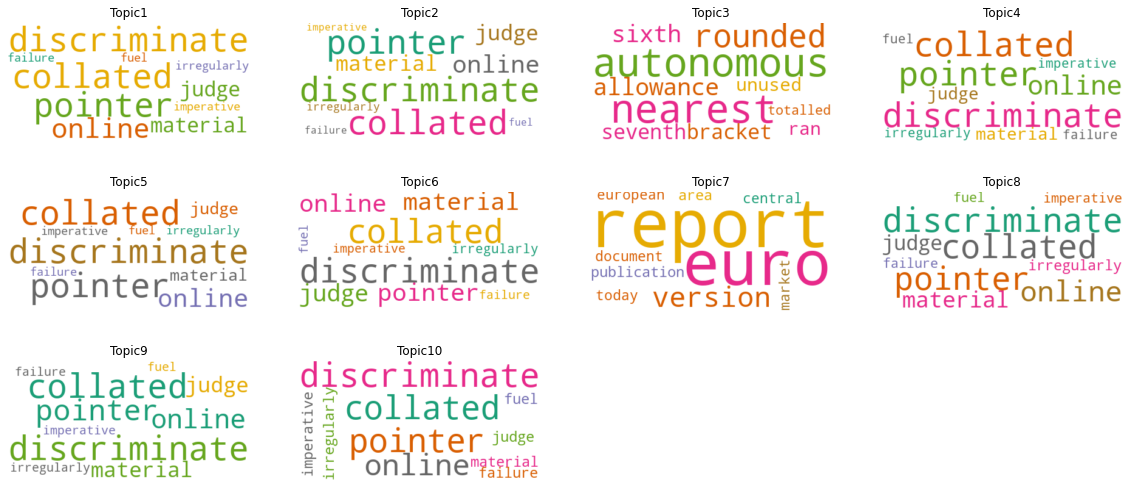

In [146]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text = topics_df_ecb_tfidf["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df_ecb_tfidf.index[i])
plt.savefig('ecb_tfidf_WordCloud.png', dpi = 100, bbox_inches = 'tight')
plt.show()

<h3>Coherence Scores<h3>

In [108]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_tfidf_lda = CoherenceModel(model = lda_model_ecb_tfidf, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
coherence_lda_tfidf_ecb = coherence_model_tfidf_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_tfidf_ecb)


Coherence Score:  0.4080424538525166


In [110]:
# Compute Coherence Score using UMass
coherence_model_tfidf_lda_umass = CoherenceModel(model = lda_model_ecb_tfidf, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence="u_mass")
coherence_lda_tfidf_umass = coherence_model_tfidf_lda_umass.get_coherence()
print('\nCoherence Score: ', coherence_lda_tfidf_umass)


Coherence Score:  -6.918306336345074


In [111]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_ecb_tfidf.log_perplexity(tfidf_weights_all_ecb))  # a measure of how good the model is. lower the better.


Perplexity:  -9.593029946463053


<h3>Optimal number of topics<h3>

In [116]:
def compute_coherence_values_tfidf(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values1 = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = tfidf_weights_all_ecb, id2word = dictionary_ecb, num_topics = num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
        coherence_values1.append(coherencemodel.get_coherence())

    return model_list, coherence_values

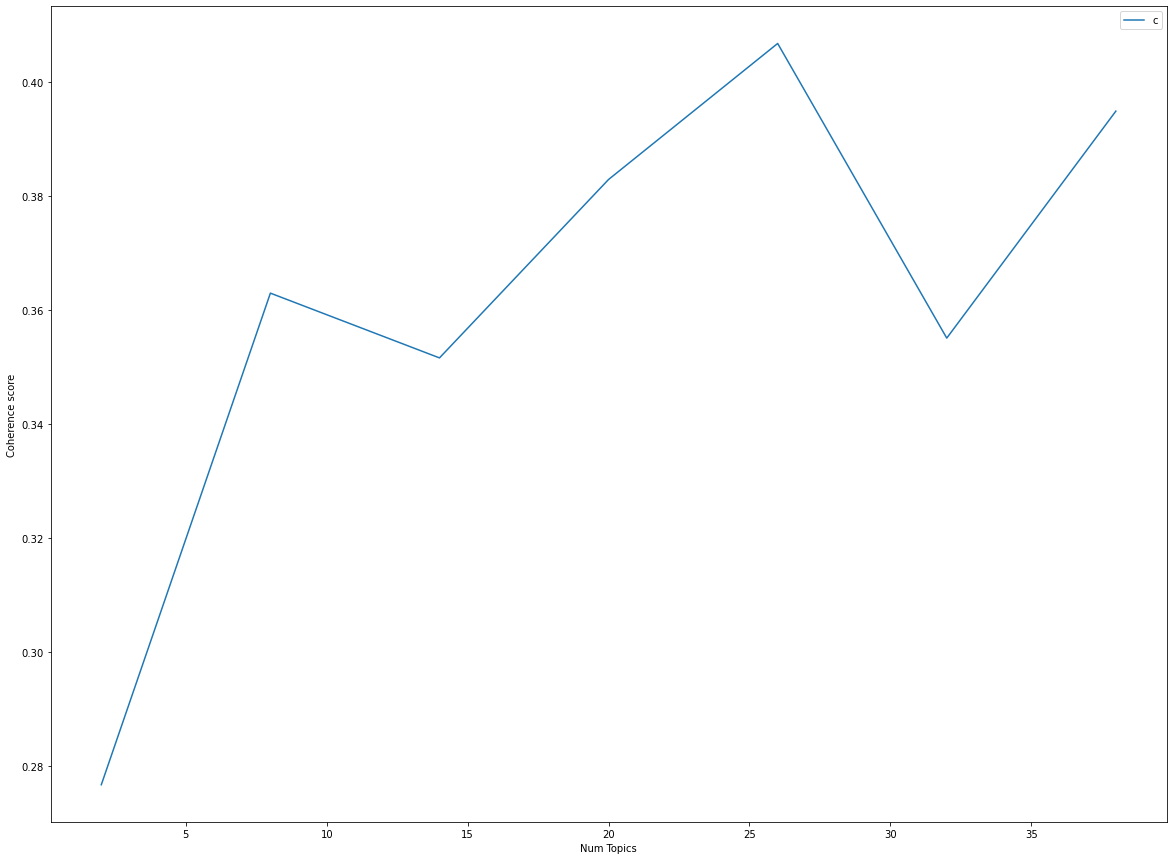

In [117]:
model_list, coherence_values1 = compute_coherence_values_tfidf(dictionary = dictionary_ecb, corpus = tfidf_weights_all_ecb,
                                                        texts = lemmatized_all_df_ecb, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

<h2> Mallet LDA <h2>

In [33]:
mallet_path = "/Users/shivangeeacharya/Downloads/mallet-2.0.8/bin/mallet"

In [34]:
import os
#from gensim.models.wrappers import LdaMallet
ldamallet_ecb = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_ecb, num_topics=10, id2word=dictionary_ecb)
from pprint import pprint
# display topics
pprint(ldamallet_ecb.show_topics(formatted=False))

[(0,
  [('market', 0.021691298571903023),
   ('data', 0.01766439721022916),
   ('central', 0.014260212553968782),
   ('report', 0.011603287944204583),
   ('european', 0.009776652274991696),
   ('trading', 0.009465293922284955),
   ('transaction', 0.008780305546330122),
   ('activity', 0.008033045499833942),
   ('bank', 0.008012288276320159),
   ('financial', 0.007680172700099634)]),
 (1,
  [('inflation', 0.05109263957612032),
   ('price', 0.019329698210005467),
   ('measure', 0.017745756297220392),
   ('forecast', 0.013708806997378786),
   ('expectation', 0.012447260341178285),
   ('model', 0.012180933824869289),
   ('underlying', 0.011017507464151048),
   ('risk', 0.009559720216986025),
   ('economic', 0.009111170294781402),
   ('euro', 0.008438345411474467)]),
 (2,
  [('wage', 0.03431908702561034),
   ('labour', 0.033617434013661594),
   ('market', 0.027034277813319026),
   ('euro', 0.019625647481272056),
   ('growth', 0.019563736921394227),
   ('unemployment', 0.01752068844542584),


In [35]:
tm_results_ecb_mallet = ldamallet_ecb[corpus_ecb]
corpus_topics_ecb_mallet = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results_ecb_mallet]

In [36]:
topics_ecb_mallet = [[(term, round(wt, 3)) for term, wt in ldamallet_ecb.show_topic(n, topn=20)] for n in range(0, ldamallet_ecb.num_topics)]

In [37]:
topics_df_ecb_mallet = pd.DataFrame([[term for term, wt in topic] for topic in topics_ecb_mallet], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet_ecb.num_topics+1)]).T
topics_df_ecb_mallet.head()

Topic 1      Topic 2 Topic 3 Topic 4   Topic 5    Topic 6   Topic 7  \
Term1  market    inflation    wage    bank    price     liquidity  fiscal     
Term2  data      price        labour  loan    global    billion    euro       
Term3  central   measure      market  area    exchange  market     country    
Term4  report    forecast     euro    euro    import    rate       area       
Term5  european  expectation  growth  credit  export    purchase   economic   

           Topic 8     Topic 9   Topic 10  
Term1  euro         growth      euro       
Term2  area         expected    pension    
Term3  consumption  projection  area       
Term4  household    euro        potential  
Term5  income       area        country

In [38]:
pd.set_option('display.max_colwidth', -1)
topics_df_ecb_mallet = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics_ecb_mallet], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet_ecb.num_topics+1)] )
topics_df_ecb_mallet

<ipython-input-38-45cf24af956f>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Terms per Topic
Topic1   market, data, central, report, european, trading, transaction, activity, bank, financial, indicator, published, number, accountability, quarter, entitled, turnover, framework, interest, survey
Topic2   inflation, price, measure, forecast, expectation, model, underlying, risk, economic, euro, area, change, error, probability, point, curve, show, real, uncertainty, data                        
Topic3   wage, labour, market, euro, growth, unemployment, area, employment, change, job, effect, development, level, curve, hour, employee, efficiency, matching, compositional, aggregate              
Topic4   bank, loan, area, euro, credit, firm, equity, financing, lending, financial, percentage, cost, net, fund, condition, business, investment, standard, finance, impact                            
Topic5   price, global, exchange, import, export, euro, production, financial, trade, economy, area, domestic, capital, country, effect, chain, change, flow, shock, risk                                
Topic6   liquidity, billion, market, rate, purchase, average, net, bond, asset, period, operation, deposit, excess, review, interest, bank, increased, security, reserve, previous                       
Topic7   fiscal, euro, country, area, economic, government, debt, rule, automatic, stabiliser, budget, public, spillover, european, structural, stabilisation, policy, level, ratio, macroeconomic       
Topic8   euro, area, consumption, household, income, price, housing, growth, wealth, good, house, real, investment, durable, quarter, demand, private, financial, increase, country                      
Topic9   growth, expected, projection, euro, area, price, oil, global, percentage, point, decline, quarter, increase, impact, activity, trade, projected, demand, real, lower                            
Topic10  euro, pension, area, potential, country, labour, age, older, scheme, social, worker, reform, expenditure, participation, government, retirement, increase, output, force, health

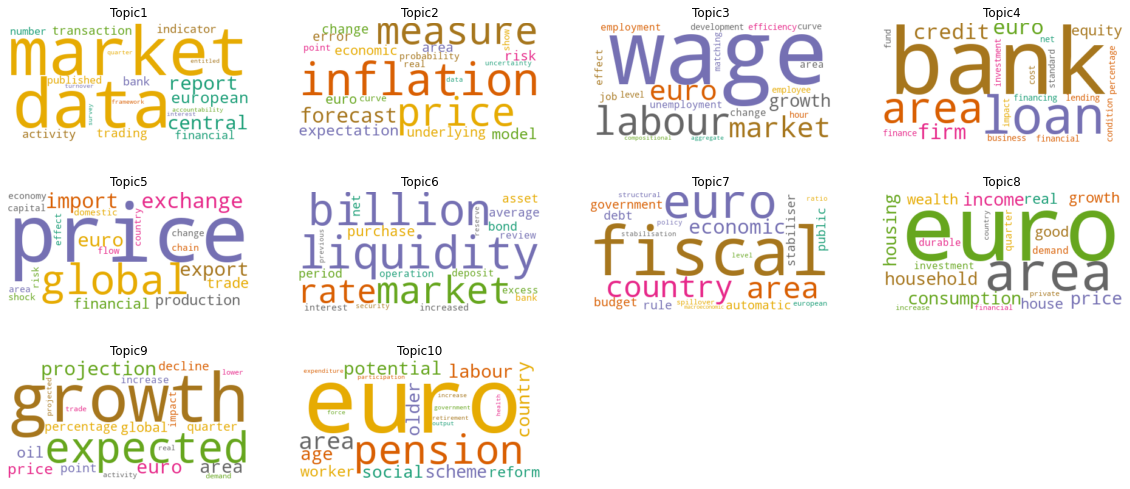

In [147]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df_ecb_mallet["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df_ecb_mallet.index[i])
plt.savefig('ecb_mallet_WordCloud.png', dpi = 100, bbox_inches = 'tight')
plt.show()

<h3>Coherence Scores<h3>

In [118]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_mallet_lda = CoherenceModel(model = ldamallet_ecb, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
coherence_lda_mallet_ecb = coherence_model_mallet_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_mallet_ecb)


Coherence Score:  0.486431761024171


In [120]:
# Compute Coherence Score using UMass
coherence_model_mallet_lda_umass = CoherenceModel(model = ldamallet_ecb, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence="u_mass")
coherence_lda_mallet_umass = coherence_model_mallet_lda_umass.get_coherence()
print('\nCoherence Score: ', coherence_lda_mallet_umass)


Coherence Score:  -0.9863696376805862


<h3>Optimal number of topics<h3>

In [128]:
def compute_coherence_values_mallet(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_mallet = []
    model_list_mallet = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_ecb, num_topics=10, id2word = dictionary_ecb)
        model_list_mallet.append(model)
        coherencemodel = CoherenceModel(model = model, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
        coherence_values_mallet.append(coherencemodel.get_coherence())

    return model_list_mallet, coherence_values_mallet

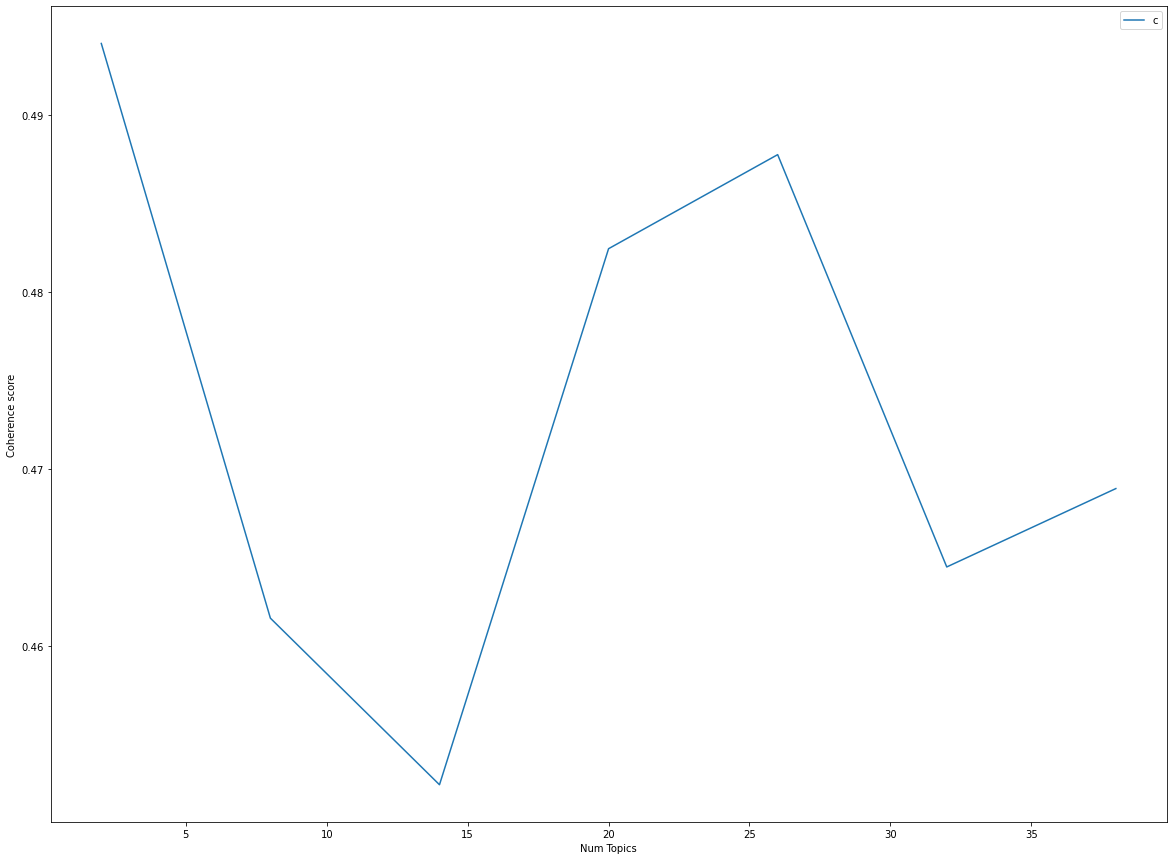

In [129]:
model_list_mallet, coherence_values_mallet = compute_coherence_values_mallet(dictionary = dictionary_ecb, corpus = corpus_ecb,
                                                        texts = lemmatized_all_df_ecb, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_mallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

<h1>Latent Semantic Analysis<h1>

In [49]:
from gensim.models import LsiModel

lsamodel = LsiModel(tfidf_weights_all_ecb, num_topics = 10, id2word = dictionary_ecb)  # train model
print(lsamodel.print_topics())

[(0, '0.325*"euro" + 0.259*"area" + 0.249*"market" + 0.168*"growth" + 0.151*"price" + 0.143*"report" + 0.127*"inflation" + 0.127*"quarter" + 0.121*"bank" + 0.118*"labour"'), (1, '0.269*"report" + 0.251*"market" + 0.226*"study" + 0.216*"money" + 0.184*"published" + -0.175*"growth" + -0.174*"price" + 0.165*"entitled" + 0.148*"second" + 0.145*"turnover"'), (2, '-0.530*"billion" + -0.315*"liquidity" + -0.212*"operation" + -0.211*"average" + -0.182*"autonomous" + -0.164*"review" + -0.164*"maintenance" + -0.159*"purchase" + -0.139*"net" + -0.127*"reserve"'), (3, '-0.249*"turnover" + -0.235*"quarter" + -0.185*"market" + -0.183*"second" + 0.177*"instrument" + 0.167*"version" + 0.166*"document" + -0.164*"swap" + 0.141*"today" + 0.137*"framework"'), (4, '-0.282*"report" + 0.228*"version" + 0.199*"document" + -0.198*"area" + 0.187*"instrument" + -0.183*"euro" + 0.166*"turnover" + -0.163*"study" + -0.160*"bond" + 0.159*"framework"'), (5, '0.430*"price" + 0.350*"inflation" + 0.207*"oil" + -0.200*"l

In [50]:
lsa_ecb = lsamodel.show_topics(num_words= 10)
w0_ecb_lsa = []
for i1 in range(10):
    t1 = list(lsa_ecb[i1])
    t2 = t1[1].split('+')
    t3 = [t2.split('*') for t2 in t2]
    #t3[0][1]
    w1 = []
    for i2 in  range(len(t3)):
        w1.append(t3[i2][1])
        for i3 in range(len(w1)):
            w1[i3] = w1[i3].replace('"','').strip()
    w0_ecb_lsa.append(w1)

In [55]:
topics_df_ecb_lsa = pd.DataFrame([[term for term in topic] for topic in w0_ecb_lsa], columns = ['Term'+str(i) for i in range(1, 11)], index=['Topic '+str(t) for t in range(1, 11)]).T
topics_df_ecb_lsa

Topic 1    Topic 2      Topic 3     Topic 4     Topic 5     Topic 6  \
Term1   euro       report     billion      turnover    report      price        
Term2   area       market     liquidity    quarter     version     inflation    
Term3   market     study      operation    market      document    oil          
Term4   growth     money      average      second      area        labour       
Term5   price      published  autonomous   instrument  instrument  area         
Term6   report     growth     review       version     euro        country      
Term7   inflation  price      maintenance  document    turnover    study        
Term8   quarter    entitled   purchase     swap        study       exchange     
Term9   bank       second     net          today       bond        euro         
Term10  labour     turnover   reserve      framework   framework   projection   

             Topic 7        Topic 8     Topic 9   Topic 10  
Term1   labour        inflation      book        loan       
Term2   loan          global         edition     fiscal     
Term3   wage          trade          chapter     country    
Term4   bank          growth         labour      bank       
Term5   financial     export         overview    exchange   
Term6   growth        import         document    growth     
Term7   employment    production     proceeding  budgetary  
Term8   document      manufacturing  financial   lending    
Term9   unemployment  market         instrument  credit     
Term10  market        book           wage        import

In [61]:
pd.set_option('display.max_colwidth', -1)
topics_df_ecb_lsa = pd.DataFrame([', '.join([term for term in topic]) for topic in w0_ecb_lsa], columns = ['Topic'], index=['Topic'+str(t) for t in range(1, 11)] )
topics_df_ecb_lsa

<ipython-input-61-536324c82f72>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Topic
Topic1   euro, area, market, growth, price, report, inflation, quarter, bank, labour                    
Topic2   report, market, study, money, published, growth, price, entitled, second, turnover             
Topic3   billion, liquidity, operation, average, autonomous, review, maintenance, purchase, net, reserve
Topic4   turnover, quarter, market, second, instrument, version, document, swap, today, framework       
Topic5   report, version, document, area, instrument, euro, turnover, study, bond, framework            
Topic6   price, inflation, oil, labour, area, country, study, exchange, euro, projection                
Topic7   labour, loan, wage, bank, financial, growth, employment, document, unemployment, market        
Topic8   inflation, global, trade, growth, export, import, production, manufacturing, market, book      
Topic9   book, edition, chapter, labour, overview, document, proceeding, financial, instrument, wage    
Topic10  loan, fiscal, country, bank, exchange, growth, budgetary, lending, credit, import

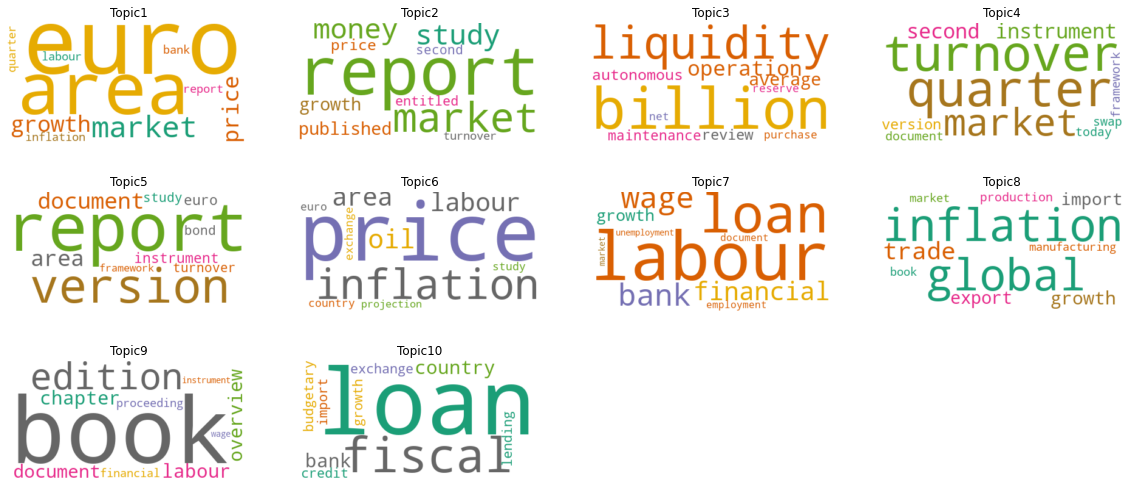

In [148]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text = topics_df_ecb_lsa["Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df_ecb_lsa.index[i])
plt.savefig('ecb_LSA_WordCloud.png', dpi = 100, bbox_inches = 'tight')
plt.show()

<h3>Coherence Scores<h3>

In [131]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lsa = CoherenceModel(model = lsamodel, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
coherence_lsa_ecb = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa_ecb)


Coherence Score:  0.3256717408466973


In [132]:
# Compute Coherence Score using UMass
coherence_model_lsa_umass = CoherenceModel(model = lsamodel, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='u_mass')
coherence_lsa_umass = coherence_model_lsa_umass.get_coherence()
print('\nCoherence Score: ', coherence_lsa_umass)


Coherence Score:  -2.228621529644199


<h3>Optimal number of topics<h3>

In [137]:
def compute_coherence_values_lsa(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_lsa = []
    model_list_lsa = []
    for num_topics in range(start, limit, step):
        model = LsiModel(tfidf_weights_all_ecb, num_topics = 10, id2word = dictionary_ecb) 
        model_list_lsa.append(model)
        coherencemodel = CoherenceModel(model = model, texts = lemmatized_all_df_ecb, dictionary = dictionary_ecb, coherence='c_v')
        coherence_values_lsa.append(coherencemodel.get_coherence())

    return model_list, coherence_values

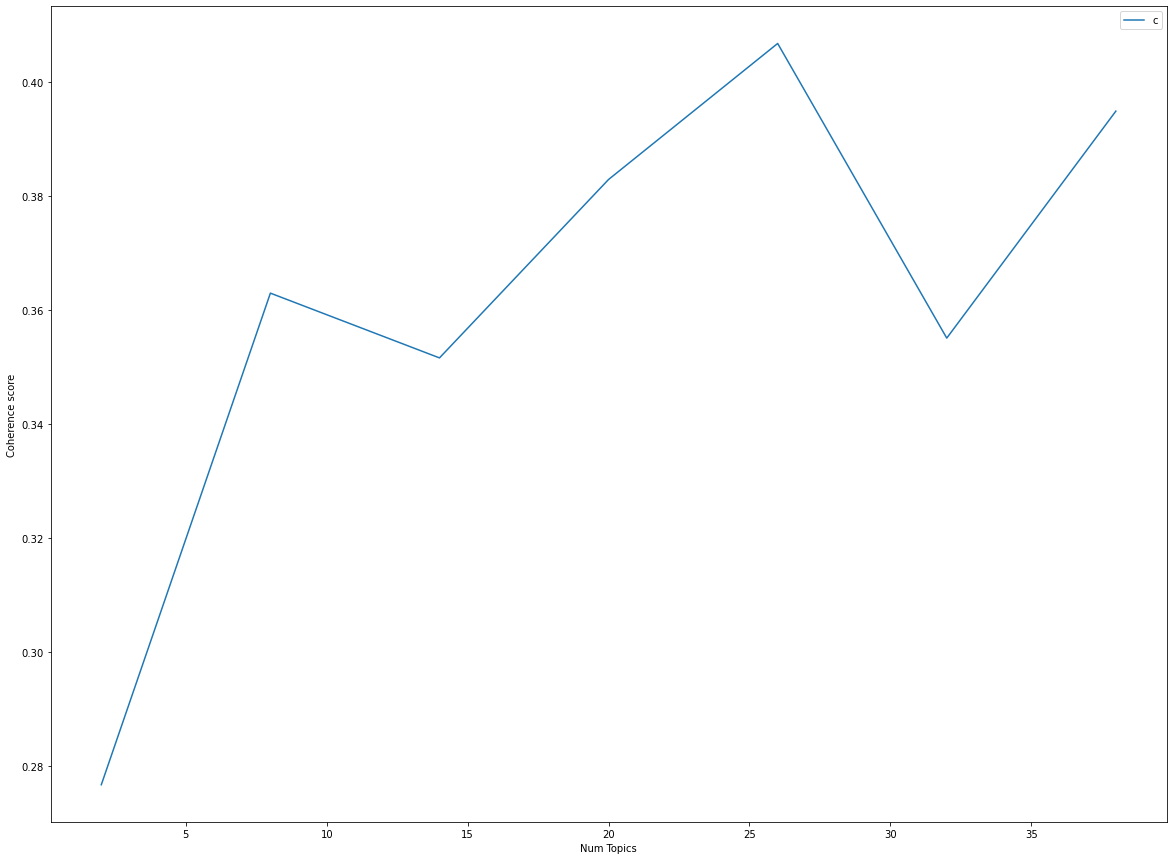

In [138]:
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsa(dictionary = dictionary_ecb, corpus = corpus_ecb,
                                                        texts = lemmatized_all_df_ecb, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_lsa)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

<h1>Results<h1>


| Model | Coherence Score | Umass Score | Perplexity Score | Optimal Numer of Topics |
| --- | --- | --- | --- | ---|
| LDA Model without tfidf | 0.42 | -1.87 | -7.09 | 8, 26 |
| --- | --- | --- | --- | ---|
| LDA Model with tfidf weights | 0.41 | -6.92 | -9.6 | 9, 26 |
| --- | --- | --- | --- | ---|
| LDA Mallet Model |  0.49 | -0.99 | - | 2, 26 |
| --- | --- | --- | --- | ---|
| LSA Model |  0.33 | -2.23 | - | 8, 27 |
| --- | --- | --- | --- | ---|

Topic coherence is used to estimate the number of topics. We used both UMass and c_v measure to see the coherence score of our LDA model and LSA model. The above plots show that coherence score increases with the number of topics but excess number of topics might have good coherence scores but may have repeated keywords in the topic, hence we cannot rely a lot on them.

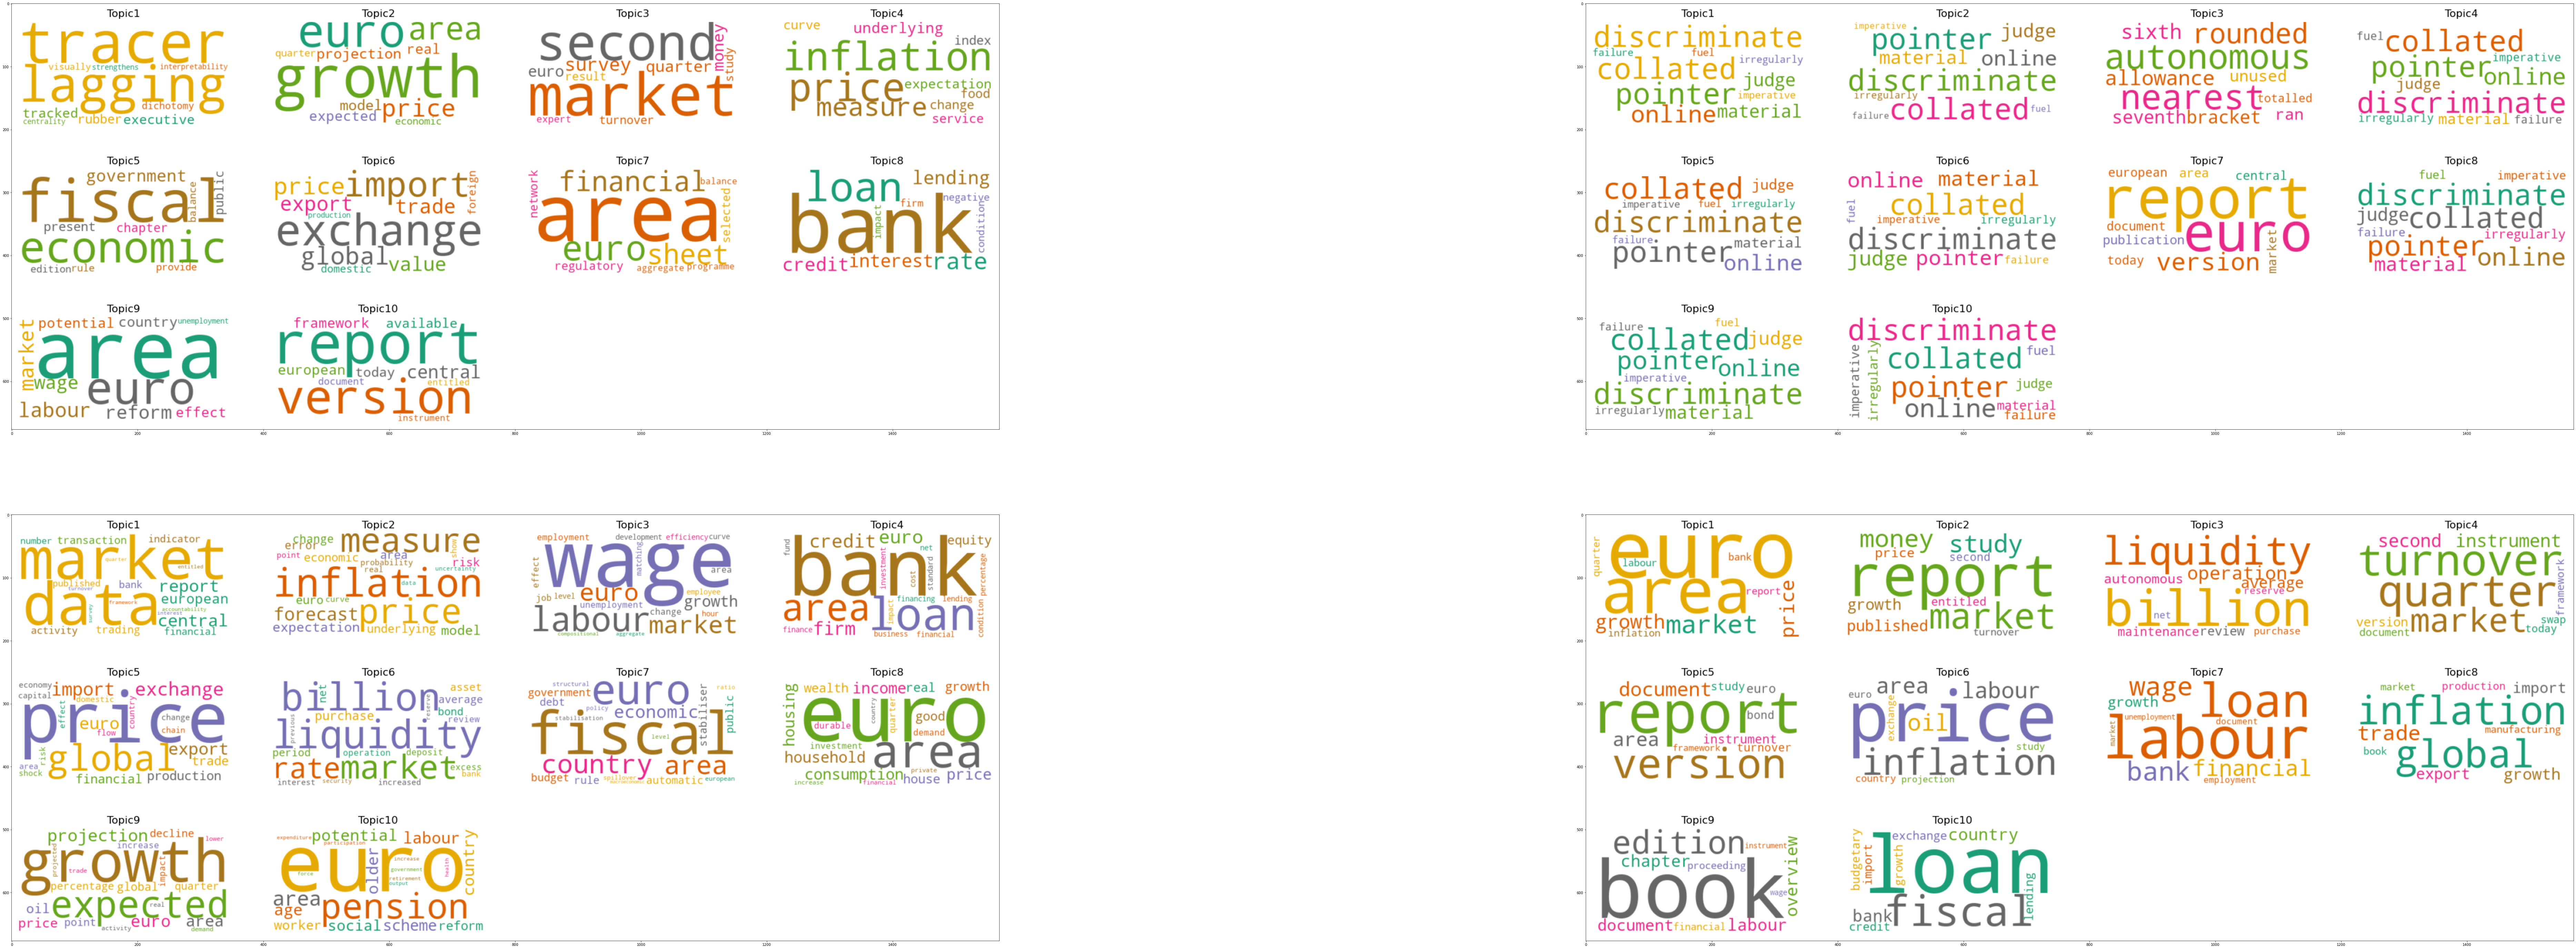

In [171]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('ecb_wo_tfidf_WordCloud.png')
img2 = mpimg.imread('ecb_tfidf_WordCloud.png')
img3 = mpimg.imread('ecb_mallet_WordCloud.png')
img4 = mpimg.imread('ecb_LSA_WordCloud.png')

plt.figure(figsize=(150,50))
plt.subplot(221)
plt.imshow(img1)

plt.subplot(222)
plt.imshow(img2)

plt.subplot(223)
plt.imshow(img3)

plt.subplot(224)
plt.imshow(img4)

plt.show()

<h1>Conclusion<h1>

Coherence measures the relative distance between words within a topic. There are two major types C_V typically is chosen for highest coherence score and most negative uMass score. The optimal coherence score as we get from the above is of LDA Mallet Model (with 0.49) and achieves it with the least number of topics (2). 

If we closely look at the word clouds of each of the models, we can see that the Mallet LDA model has wordclouds that are most closely related to the Monetary Policy.
